# Bitcoin & Twitter

In [1]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql.functions import col, desc, asc, lit
from pyspark.sql import functions as F
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
import re
import yfinance as yf
import datetime
import folium
from geopy.geocoders import Nominatim


sc = SparkContext("local").getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)
plt.style.use('ggplot')

## Data Exploration

### BITCOIN

 - Unix Timestamp - Date represented as epoc value
 - Date - date and time when the data point was collected
 - Symbol - Symbol of the currency
 - Open - Open value of the currency
 - High - Highest value of currency in the given minute
 - Low - Lowest value of currency in the given minute
 - Close - Close value of the currency in the given minute
 - Volume - Volume of the currency transacted in the given minute.

### TWITTER

 - user_name    The name of the user, as they’ve defined it.
 - user_location    The user-defined location for this account’s profile.
 - user_description	The user-defined UTF-8 string describing their account.
 - user_created	Time and date, when the account was created.
 - user_followers	The number of followers an account currently has.
 - user_friends	The number of friends a account currently has.
 - user_favourites	The number of favorites a account currently has
 - user_verified    When true, indicates that the user has a verified account
 - date UTC time and date when the Tweet was created
 - text The actual UTF-8 text of the Tweet
 - hashtags	All the other hashtags posted in the tweet along with #Bitcoin & #btc
 - source   Utility used to post the Tweet, Tweets from the Twitter website have a source value - web
 - is_retweet	Indicates whether this Tweet has been Retweeted by the authenticating user.

In [2]:
tweets_schema = StructType([
    StructField('user_name', StringType(), True),
    StructField('user_location', StringType(), True),
    StructField('user_description', StringType(), True),
    StructField('user_created', StringType(), True),
    StructField('user_followers', FloatType(), True),
    StructField('user_friends', IntegerType(), True),
    StructField('user_favourites', IntegerType(), True),
    StructField('user_verified', BooleanType(), True),
    StructField('date', StringType(), True),
    StructField('text', StringType(), True),
    StructField('hashtags', StringType(), True),
    StructField('source', StringType(), True),
    StructField('is_retweet', BooleanType(), True),
])


tweets_df = spark.read.csv(
    "./data/tweets.csv", 
    header=True,
    sep=',',
    multiLine=True,
    schema=tweets_schema

)
tweets_df.show(3)

+-------------+---------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+--------------------+--------------------+----------+
|    user_name|  user_location|    user_description|       user_created|user_followers|user_friends|user_favourites|user_verified|               date|                text|            hashtags|              source|is_retweet|
+-------------+---------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+--------------------+--------------------+----------+
|DeSota Wilson|    Atlanta, GA|Biz Consultant, r...|2009-04-26 20:05:09|        8534.0|        7605|           4838|        false|2021-02-10 23:59:04|Blue Ridge Bank s...|         ['bitcoin']|     Twitter Web App|     false|
|     CryptoND|           null|😎 BITCOINLIVE is...|2019-10-17 20:12:10|        6769.0|        1532| 

In [3]:
# tweets_df = tweets_df.withColumn("date", datetime.datetime.strptime(str(col('date')), '%Y-%m-%d').strftime('%d/%m/%y')).filter((tweets_df.date > datetime.datetime(2020, 3, 20) )& (tweets_df.date < datetime.datetime(2021,9,10)))
tweets_df = tweets_df.withColumn("date", F.to_date(F.col("date"))).filter((tweets_df.date > datetime.datetime(2020, 3, 20) )& (tweets_df.date < datetime.datetime(2021,9,10)))
btc_stock=yf.Ticker("BTC-USD")
start = tweets_df.agg({"date": "min"}).collect()[0]
end = tweets_df.agg({"date": "max"}).collect()[0]
# print(datetime.datetime.strptime(str(start), '%Y-%m-%d'))
# print(datetime.datetime.strptime(str(end), '%Y-%m-%d'))
print(start['min(date)'])
print(end['max(date)'])
btc_stock = btc_stock.history(start=start['min(date)'], end=end['max(date)'])
btc_df = spark.createDataFrame(btc_stock)
btc_df.show()

2021-01-07
2021-08-26
+---------------+--------------+---------------+---------------+------------+---------+------------+
|           Open|          High|            Low|          Close|      Volume|Dividends|Stock Splits|
+---------------+--------------+---------------+---------------+------------+---------+------------+
| 34013.61328125|36879.69921875| 33514.03515625| 36824.36328125| 75289433811|        0|           0|
|      36833.875| 40180.3671875| 36491.19140625| 39371.04296875| 84762141031|        0|           0|
|   39381.765625|41946.73828125| 36838.63671875|   40797.609375| 88107519480|        0|           0|
|   40788.640625| 41436.3515625|      38980.875|   40254.546875| 61984162837|        0|           0|
|    40254.21875|41420.19140625| 35984.62890625| 38356.44140625| 79980747690|        0|           0|
|    38346.53125|   38346.53125|30549.599609375|    35566.65625|123320567399|        0|           0|
|   35516.359375|36568.52734375|  32697.9765625|  33922.9609375| 7477

## Bitcoin

##### Open

In [4]:
btc_df.describe(["Open"]).show()

+-------+-----------------+
|summary|             Open|
+-------+-----------------+
|  count|              232|
|   mean|44535.74531081627|
| stddev|9627.652800056276|
|    min|   29796.28515625|
|    max|   63523.75390625|
+-------+-----------------+



##### High

In [5]:
btc_df.describe(["High"]).show()

+-------+-----------------+
|summary|             High|
+-------+-----------------+
|  count|              232|
|   mean|45944.96184671336|
| stddev|9708.891947732267|
|    min|       31006.1875|
|    max|   64863.09765625|
+-------+-----------------+



##### Low

In [6]:
btc_df.describe(["Low"]).show()

+-------+-----------------+
|summary|              Low|
+-------+-----------------+
|  count|              232|
|   mean|42901.24442685884|
| stddev|9547.680708384754|
|    min|   28893.62109375|
|    max|   62208.96484375|
+-------+-----------------+



##### Close

In [7]:
btc_df.describe(["Close"]).show()

+-------+------------------+
|summary|             Close|
+-------+------------------+
|  count|               232|
|   mean|44591.348001414335|
| stddev| 9618.853628791798|
|    min|    29807.34765625|
|    max|    63503.45703125|
+-------+------------------+



##### Volume

In [8]:
btc_df.describe(["Volume"]).show()

+-------+--------------------+
|summary|              Volume|
+-------+--------------------+
|  count|                 232|
|   mean|5.355412655096551...|
| stddev|2.821178198995562...|
|    min|         18787986667|
|    max|        350967941479|
+-------+--------------------+



## TWITTER

In [9]:
tweets_df.count()

1204250

##### user_name
Should be dropped

In [10]:
tweets_df.drop("user_name")

DataFrame[user_location: string, user_description: string, user_created: string, user_followers: float, user_friends: int, user_favourites: int, user_verified: boolean, date: date, text: string, hashtags: string, source: string, is_retweet: boolean]

##### user_location

In [11]:
tweets_df.select(F.countDistinct("user_location")).show()
tweets_df.select([F.count(F.when(col("user_location").isNull(), "user_location"))]).show()

+-----------------------------+
|count(DISTINCT user_location)|
+-----------------------------+
|                        40916|
+-----------------------------+

+---------------------------------------------------------------+
|count(CASE WHEN (user_location IS NULL) THEN user_location END)|
+---------------------------------------------------------------+
|                                                         571975|
+---------------------------------------------------------------+



##### user_description

Should be dropped

In [12]:
tweets_df.drop("user_description")

DataFrame[user_name: string, user_location: string, user_created: string, user_followers: float, user_friends: int, user_favourites: int, user_verified: boolean, date: date, text: string, hashtags: string, source: string, is_retweet: boolean]

##### user_created

In [13]:
tweets_df.describe(["user_created"]).show()

tweets_df.select([F.count(F.when(col("user_created").isNull(), "user_created"))]).show()

+-------+--------------------+
|summary|        user_created|
+-------+--------------------+
|  count|             1204250|
|   mean|                null|
| stddev|                null|
|    min|"" & ""The Notori...|
|    max| 2021-08-26 23:33:23|
+-------+--------------------+

+-------------------------------------------------------------+
|count(CASE WHEN (user_created IS NULL) THEN user_created END)|
+-------------------------------------------------------------+
|                                                            0|
+-------------------------------------------------------------+



##### user_followers

In [14]:
tweets_df.select([F.count(F.when(col("user_followers").isNull(), "user_followers"))]).show()

+-----------------------------------------------------------------+
|count(CASE WHEN (user_followers IS NULL) THEN user_followers END)|
+-----------------------------------------------------------------+
|                                                                1|
+-----------------------------------------------------------------+



##### user_followers

In [15]:
tweets_df.select([F.count(F.when(col("user_followers").isNull(), "user_followers"))]).show()

+-----------------------------------------------------------------+
|count(CASE WHEN (user_followers IS NULL) THEN user_followers END)|
+-----------------------------------------------------------------+
|                                                                1|
+-----------------------------------------------------------------+



##### user_friends

In [16]:
tweets_df.select([F.count(F.when(col("user_friends").isNull(), "user_friends"))]).show()

+-------------------------------------------------------------+
|count(CASE WHEN (user_friends IS NULL) THEN user_friends END)|
+-------------------------------------------------------------+
|                                                       968121|
+-------------------------------------------------------------+



##### user_favourites

In [17]:
tweets_df.select([F.count(F.when(col("user_favourites").isNull(), "user_favourites"))]).show()

+-------------------------------------------------------------------+
|count(CASE WHEN (user_favourites IS NULL) THEN user_favourites END)|
+-------------------------------------------------------------------+
|                                                             968121|
+-------------------------------------------------------------------+



##### user_verified

In [18]:
tweets_df.select(F.count(F.when(col("user_verified").isNull(), "user_verified")),
                 F.count(F.when(col("user_verified") == "false", "user_verified")),
                 F.count(F.when(col("user_verified") == "true", "user_verified"))).show()

+---------------------------------------------------------------+---------------------------------------------------------------+--------------------------------------------------------------+
|count(CASE WHEN (user_verified IS NULL) THEN user_verified END)|count(CASE WHEN (user_verified = false) THEN user_verified END)|count(CASE WHEN (user_verified = true) THEN user_verified END)|
+---------------------------------------------------------------+---------------------------------------------------------------+--------------------------------------------------------------+
|                                                              1|                                                        1194538|                                                          9711|
+---------------------------------------------------------------+---------------------------------------------------------------+--------------------------------------------------------------+



##### date

In [19]:
tweets_df.select(F.countDistinct("date")).show()
tweets_df.select([F.count(F.when(col("date").isNull(), "date"))]).show()

+--------------------+
|count(DISTINCT date)|
+--------------------+
|                  78|
+--------------------+

+---------------------------------------------+
|count(CASE WHEN (date IS NULL) THEN date END)|
+---------------------------------------------+
|                                            0|
+---------------------------------------------+



##### text

In [20]:
tweets_df.select(F.count(F.when(col("text").isNull(), "text"))).show()

+---------------------------------------------+
|count(CASE WHEN (text IS NULL) THEN text END)|
+---------------------------------------------+
|                                            0|
+---------------------------------------------+



##### hashtags

In [21]:
tweets_df.select(F.countDistinct("hashtags")).show()
tweets_df.select([F.count(F.when(col("hashtags").isNull(), "hashtags"))]).show()

+------------------------+
|count(DISTINCT hashtags)|
+------------------------+
|                  285786|
+------------------------+

+-----------------------------------------------------+
|count(CASE WHEN (hashtags IS NULL) THEN hashtags END)|
+-----------------------------------------------------+
|                                                27492|
+-----------------------------------------------------+



##### source

In [22]:
tweets_df.select(F.countDistinct("source")).show()
tweets_df.select([F.count(F.when(col("source").isNull(), "source"))]).show()

+----------------------+
|count(DISTINCT source)|
+----------------------+
|                  3605|
+----------------------+

+-------------------------------------------------+
|count(CASE WHEN (source IS NULL) THEN source END)|
+-------------------------------------------------+
|                                            16657|
+-------------------------------------------------+



##### is_retweet

In [23]:
tweets_df.select(F.count(F.when(col("is_retweet").isNull(), "is_retweet")).alias("null values"),
                 F.count(F.when(col("is_retweet") == "false", "is_retweet")),
                 F.count(F.when(col("is_retweet") == "true", "is_retweet"))).show()

+-----------+---------------------------------------------------------+--------------------------------------------------------+
|null values|count(CASE WHEN (is_retweet = false) THEN is_retweet END)|count(CASE WHEN (is_retweet = true) THEN is_retweet END)|
+-----------+---------------------------------------------------------+--------------------------------------------------------+
|      17431|                                                  1186819|                                                       0|
+-----------+---------------------------------------------------------+--------------------------------------------------------+



## Preparing Data    Date|
+-------+-------------+

In [24]:
from pyspark.sql.functions import udf

def conv_to_int(val):
    if isinstance(val, str):
        return 0
    else:
        return float(val)

conv_to_int_udf = udf(lambda x : conv_to_int(x), IntegerType())

tweets_df = tweets_df.withColumn("user_followers", conv_to_int_udf(col("user_followers")))\
    .withColumn("user_friends", conv_to_int_udf(col("user_friends")))\
    .withColumn("user_favourites", conv_to_int_udf(col("user_favourites")))

### Text cleaning

In [25]:
def clean_text(text):
    if(isinstance(text, str)):
        text = text.replace("#","")
        text = re.sub('\\n', '', text)
        text = re.sub('https:\/\/\S+', '', text)
        return text
    else:
        return ""

clean_text_udf = udf(lambda x : clean_text(x), StringType())

tweets_df.withColumn("text", clean_text_udf(col("text")))

DataFrame[user_name: string, user_location: string, user_description: string, user_created: string, user_followers: int, user_friends: int, user_favourites: int, user_verified: boolean, date: date, text: string, hashtags: string, source: string, is_retweet: boolean]

### Generating impact score

In [26]:
from pyspark.sql.functions import struct

def generate_impact_score(tweet):
    coef_verified = 1.1 if tweet.user_verified else 1
    coef_hashtags = 1+(tweet.hashtags_len/20)
    return ((tweet.user_followers + (tweet.user_friends/4))*coef_verified*coef_hashtags)/100

generate_impact_score_udf = udf(lambda x : generate_impact_score(x), FloatType())

tweets_df.withColumn("impact_score", generate_impact_score_udf(struct([tweets_df[x] for x in tweets_df.columns])))

DataFrame[user_name: string, user_location: string, user_description: string, user_created: string, user_followers: int, user_friends: int, user_favourites: int, user_verified: boolean, date: date, text: string, hashtags: string, source: string, is_retweet: boolean, impact_score: float]

## Data visualisation

### Twitter

### Tweets / user

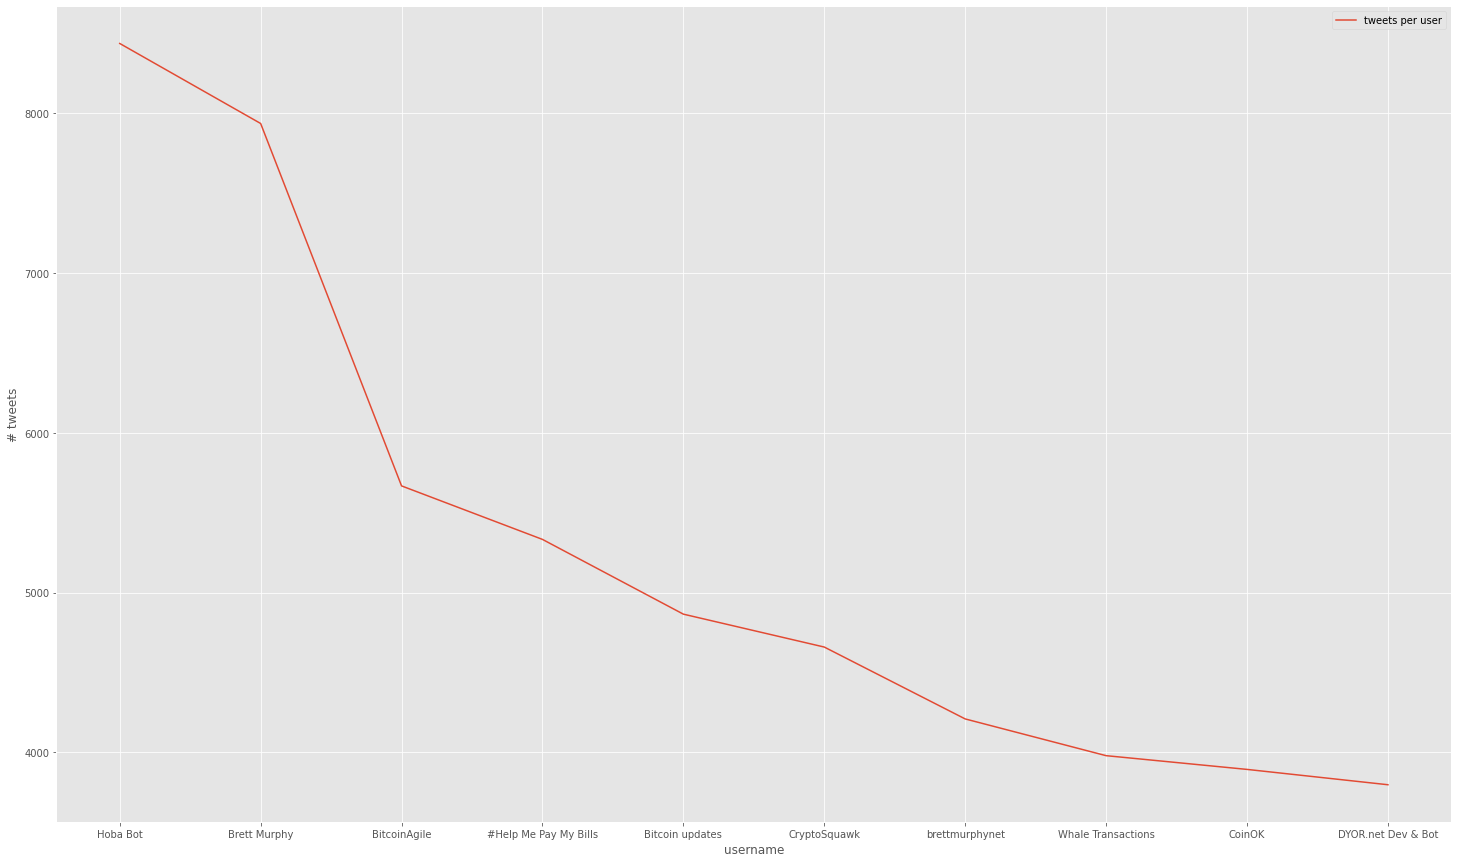

In [27]:
%matplotlib inline

user_volume = tweets_df.groupby("user_name").count().sort(desc("count"))

n = 10
x_rows = user_volume.limit(n).select("user_name").collect()
x = list(map(lambda r : str(r['user_name']), x_rows))

y_rows = user_volume.limit(n).select("count").collect()
y = list(map(lambda r : int(r['count']), y_rows))

rc('figure', figsize=(25, 15))
fig, ax = plt.subplots()
ax.plot(x, y,
        label='tweets per user')

ax.set_xlabel('username')
ax.set_ylabel('# tweets')
ax.legend()

### Bitcoin Value

In [39]:
# df_location = tweets_df.groupBy('user_location').count().sort(col("count").desc()).show()
geolocator = Nominatim(user_agent="example")
location_df = tweets_df.groupBy('user_location').count().filter("count >= 500").where("user_location not in ('Decentralized', 'Moon', '🇦🇺', 'Everywhere', 'Road Warrior', 'Mars', 'Cloud Engineer', 'Planet Earth', 'Earth', 'Blockchain', 'The Blockchain')").sort(col("count").desc()).dropna().collect()

def coords(location_string):
    try:
        location_obj = geolocator.geocode(location_string).raw
        return (location_obj['lat'], location_obj['lon'])
    except:
        return (20, 20)

locations = list(map(lambda r : [r['user_location'], r['count'], coords(r['user_location']) ], location_df)) 
map_tweets = folium.Map(location=[65,26], zoom_start=4)

for location_name, count, location_coords in locations:
    folium.Circle(location=location_coords,
                  popup = f"{location_name}: {count}",
                  radius = count*50,
                  color="crimson",
                  fill_color="crimson",
                  tooltip=count).add_to(map_tweets)
map_tweets

In [ ]:
date_df = tweets_df.withColumn("date", F.to_date(F.col("date")))
date_df = date_df. groupby("date").count().dropna().sort(asc("date")).filter((date_df.date > datetime.datetime(2020, 3, 20) )& (date_df.date < datetime.datetime.today()))
date_df.sort(desc("date")).show(1)
date_df.sort(asc("date")).show(1)
x_rows = date_df.select("date").collect() 
x = list(map(lambda r : (r['date']), x_rows)) 
y_rows = date_df.select("count").collect() 
tweets_y = list(map(lambda r : int(r['count']), y_rows))

In [ ]:
y_rows = btc_df.select("Volume").collect() 
btc_y = list(map(lambda r : float(r['Volume']), y_rows))

In [ ]:
print(btc_df.select("Volume").count())
print(len(tweets_y))

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x,tweets_y,label='Tweet Volume')
ax.set_yscale('log')
ax.tick_params(axis='y')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc=0)

plt.show()

In [ ]:
fig, ax2 = plt.subplots(figsize=(16,8))
ax2.plot(btc_y,color='orange',label='Volume')
ax2.set_yscale('log')
ax2.tick_params(axis='y')

lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines2,labels2, loc=0)
plt.show()